In [2]:
import os
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

In [49]:
# ### V1: 2021-07-28 - 

# ## Read the list of unique patient IDs
# dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
# filename = os.path.join(dir_path, '116_plcp_mv_pseudoid_pid.csv')
# df = pd.read_csv(filename, sep=',', header=0)

# ## Read the CSV file into a DataFrame
# lab_dict_dirpath = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/dicts/'
# lab_dict_filename = os.path.join(lab_dict_dirpath, 'lab_data_dict.csv')
# df_lab_dict = pd.read_csv(lab_dict_filename, sep=',', header=0, index_col=0)
# print('df_lab_dict', df_lab_dict)

# ## Dataframe to store the lab markers
# patients_labmarkers_df = pd.DataFrame()

# for row in df.itertuples(5):
#     patient_id = row.pseudoid_pid
#     ## Read the folder with the lab markers
#     dir_lab_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/06_clinical_data/lab_data_features/'
#     filename = os.path.join(dir_lab_path, 'patient_'+ str(patient_id) +'.csv')

#     try:
#         ## Read the CSV file into a DataFrame per patient
#         df_lab = pd.read_csv(filename, sep=',', header=0, index_col=0)
#         print('+ patient_id: ', patient_id, df_lab.shape)

#         ## Added the patient ID to the dataframe and append the corrsponding lab markers to the lab dictionary
#         for row_labdata in df_lab.itertuples():
#             print('row_labdata', row_labdata)
#             print('row_labdata', type(row_labdata))

#             ## Add the row_labdata into patients_labmarkers_df

#     ## make an exception for FileNotFoundError
#     except FileNotFoundError:
#         print('- patient_id: ', patient_id)
#         continue
    
# # ## Save the dataframe to a CSV file
# # filename = os.path.join(dir_path, '116_plcp_mv_pseudoid_pid_lab.csv')
# # df_lab.to_csv(filename, sep=',', header=True, index=False)

# print(df_lab)
# print(df_lab.shape)

In [46]:
# ### V2: 2021-07-28 - Saving only one row per patient_id (the first one)

# import os
# import pandas as pd

# # Read the list of unique patient IDs
# dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
# filename = os.path.join(dir_path, '116_plcp_mv_pseudoid_pid.csv')
# df = pd.read_csv(filename, sep=',', header=0)

# # Read the lab markers dictionary
# lab_dict_dirpath = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/dicts/'
# lab_dict_filename = os.path.join(lab_dict_dirpath, 'lab_data_dict.csv')
# df_lab_markers = pd.read_csv(lab_dict_filename, sep=',', header=0, index_col=0)

# # Iterate through the patient IDs
# for row in df.itertuples():
#     patient_id = row.pseudoid_pid
#     dir_lab_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/06_clinical_data/lab_data_features/'
#     filename = os.path.join(dir_lab_path, f'patient_{patient_id}.csv')

#     try:
#         # Read the CSV file into a DataFrame per patient
#         df_lab = pd.read_csv(filename, sep=',', header=0)   #, index_col=0)

#         # ## Print the days for the row 0
#         # print(df_lab.iloc[0])
        
#         # Append the laboratory values to df_lab_markers using the corresponding column names per each day 'days' at each patient_id
#         for col in df_lab.columns:
#             df_lab_markers.loc[patient_id, col] = df_lab[col].values[0] if col in df_lab.columns else None
    
#     # Make an exception for FileNotFoundError
#     except FileNotFoundError:
#         continue

# # Save the updated df_lab_markers to a CSV file
# updated_lab_markers_filename = os.path.join(dir_path, '999_116_plcp_lab_markers.csv')
# df_lab_markers.to_csv(updated_lab_markers_filename, sep=',', header=True, index=True)

# # Print some information about the updated dataframe
# print('Updated df_lab_markers:')
# print(df_lab_markers)
# print('Shape:', df_lab_markers.shape)

In [47]:
import os
import pandas as pd

# Read the list of unique patient IDs
dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
filename = os.path.join(dir_path, '116_plcp_mv_pseudoid_pid.csv')
df = pd.read_csv(filename, sep=',', header=0)

# Read the lab markers dictionary
lab_dict_dirpath = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/dicts/'
lab_dict_filename = os.path.join(lab_dict_dirpath, 'lab_data_dict.csv')
df_lab_markers = pd.read_csv(lab_dict_filename, sep=',', header=0, index_col=0)

# Iterate through the patient IDs
for row in df.itertuples():
    patient_id = row.pseudoid_pid
    dir_lab_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/06_clinical_data/lab_data_features/'
    filename = os.path.join(dir_lab_path, f'patient_{patient_id}.csv')

    try:
        # Read the first row of the CSV file into a DataFrame per patient
        df_lab = pd.read_csv(filename, sep=',', nrows=1, header=0)  # Read only the first row

        # Append the laboratory values to df_lab_markers using the corresponding column names per the days column
        days_col = df_lab['days'].iloc[0]
        for col in df_lab.columns:
            df_lab_markers.loc[patient_id, f"{col}_{days_col}"] = df_lab[col].iloc[0] if col in df_lab.columns else None
    
    # Make an exception for FileNotFoundError
    except FileNotFoundError:
        continue

# Save the updated df_lab_markers to a CSV file
updated_lab_markers_filename = os.path.join(dir_path, '999_116_plcp_lab_markers.csv')
df_lab_markers.to_csv(updated_lab_markers_filename, sep=',', header=True, index=True)

# Print some information about the updated dataframe
print('Updated df_lab_markers:')
print(df_lab_markers)
print('Shape:', df_lab_markers.shape)

/tmp/ipykernel_24281/1137397173.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lab_markers.loc[patient_id, f"{col}_{days_col}"] = df_lab[col].iloc[0] if col in df_lab.columns else None
/tmp/ipykernel_24281/1137397173.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lab_markers.loc[patient_id, f"{col}_{days_col}"] = df_lab[col].iloc[0] if col in df_lab.columns else None
/tmp/ipykernel_24281/1137397173.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` m

Updated df_lab_markers:
             days ALAT  aPTT ASAT  Basophile Bicarbonat Bicarbonat akt.  \
pseudoid_pid                                                              
1000037       NaN   NaN  NaN   NaN       NaN        NaN             NaN   
1000065       NaN   NaN  NaN   NaN       NaN        NaN             NaN   
1000066       NaN   NaN  NaN   NaN       NaN        NaN             NaN   
1000095       NaN   NaN  NaN   NaN       NaN        NaN             NaN   
1000104       NaN   NaN  NaN   NaN       NaN        NaN             NaN   
...           ...   ...  ...   ...       ...        ...             ...   
1001231       NaN   NaN  NaN   NaN       NaN        NaN             NaN   
1001260       NaN   NaN  NaN   NaN       NaN        NaN             NaN   
1001269       NaN   NaN  NaN   NaN       NaN        NaN             NaN   
1001343       NaN   NaN  NaN   NaN       NaN        NaN             NaN   
1001362       NaN   NaN  NaN   NaN       NaN        NaN             NaN   



/tmp/ipykernel_24281/1137397173.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lab_markers.loc[patient_id, f"{col}_{days_col}"] = df_lab[col].iloc[0] if col in df_lab.columns else None
/tmp/ipykernel_24281/1137397173.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lab_markers.loc[patient_id, f"{col}_{days_col}"] = df_lab[col].iloc[0] if col in df_lab.columns else None


Number of NaN values: 0
Number of infinite values: 0


/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


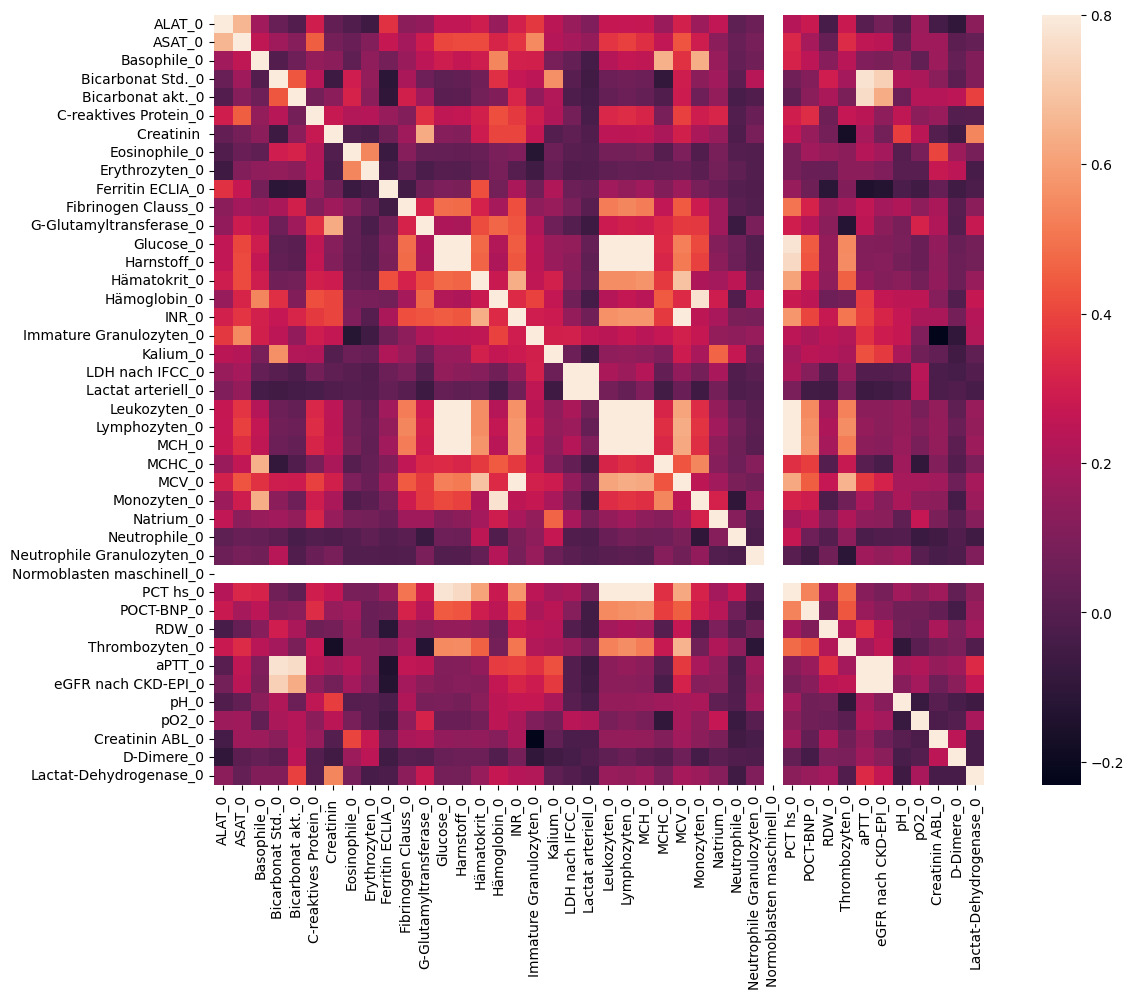

In [48]:
import os
import pandas as pd
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# Load data
dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
filename = os.path.join(dir_path, 'lab_data_exploration.csv')
df = pd.read_csv(filename, sep=',', header=0, index_col=0)

# Extract the feature columns
feature_names = df.columns

# Extract the sample ids
samples = df.values

# Standardize the data before calculating distances
scaler = StandardScaler()
scaled_samples = scaler.fit_transform(samples)

# Calculate pairwise Euclidean distances
similarities = euclidean_distances(scaled_samples, scaled_samples)

# Debugging: Output non-finite values in the similarities matrix
print("Number of NaN values:", np.sum(np.isnan(similarities)))
print("Number of infinite values:", np.sum(np.isinf(similarities)))

# Replace NaN with infinity
similarities[np.isnan(similarities)] = np.inf

# Multidimensional scaling
seed = np.random.RandomState(seed=3)
mds = manifold.MDS(n_components=2, max_iter=5000, eps=1e-12, random_state=seed,
                   n_init=10, dissimilarity="precomputed", n_jobs=1, metric=False)
pos = mds.fit_transform(similarities)

### features as a heatmap
# Construct a pandas dataframe from the samples
d = pd.DataFrame(data=samples, columns=feature_names)
corr = d.corr()

# Set up the matplotlib figure, make it big!
f, ax = plt.subplots(figsize=(15, 10))

# Draw the heatmap using seaborn
sns.heatmap(corr, vmax=.8, square=True)

# ### Clustermap
# # Choose a subset of features for clustering
# dd = d.iloc[:,1:50]
# pp = sns.clustermap(dd.corr(), linewidths=.5, figsize=(13,13))
# _ = plt.setp(pp.ax_heatmap.get_yticklabels(), rotation=0)
plt.show()

Number of NaN values: 0
Number of infinite values: 0


<Figure size 1500x1000 with 0 Axes>

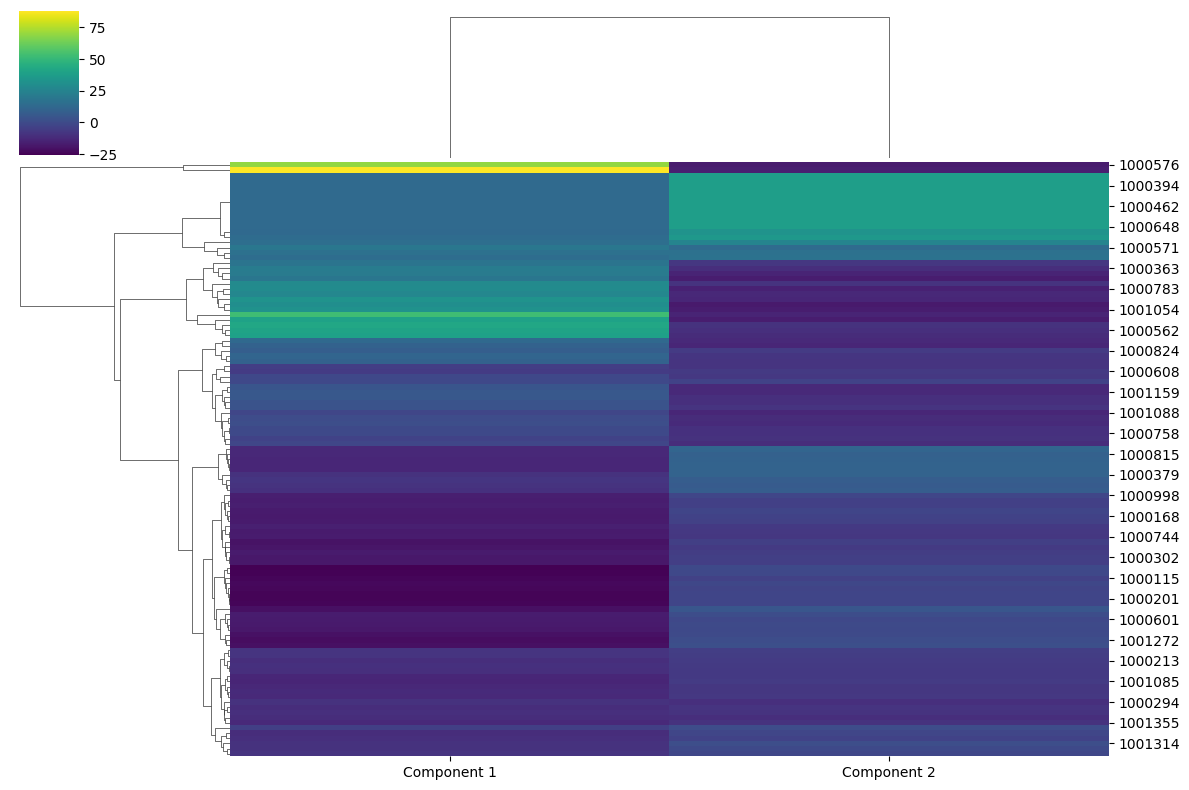

In [42]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load data
dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
filename = os.path.join(dir_path, 'lab_data_exploration.csv')
df = pd.read_csv(filename, sep=',', header=0, index_col=0)

# Extract the feature columns and sample data
feature_names = df.columns
samples = df.values

# Extract patients ids
patient_ids = df.index.values

# Standardize the data before calculating distances
scaler = StandardScaler()
scaled_samples = scaler.fit_transform(samples)

# Calculate pairwise Euclidean distances
similarities = euclidean_distances(scaled_samples)

# Debugging: Output non-finite values in the similarities matrix
nan_count = np.sum(np.isnan(similarities))
inf_count = np.sum(np.isinf(similarities))
print("Number of NaN values:", nan_count)
print("Number of infinite values:", inf_count)

# Replace NaN with infinity
similarities[np.isnan(similarities)] = np.inf

# Multidimensional scaling
seed = np.random.RandomState(seed=3)
mds = PCA(n_components=2, random_state=seed)
pos = mds.fit_transform(similarities)

# Create a DataFrame with the MDS positions and patient IDs
mds_df = pd.DataFrame(pos, columns=['Component 1', 'Component 2'], index=patient_ids)

# Set up the matplotlib figure, make it big!
plt.figure(figsize=(15, 10))

# Create a cluster map using seaborn
sns.clustermap(mds_df, cmap='viridis', method='average', metric='euclidean', figsize=(12, 8))

plt.show()

Number of NaN values: 0
Number of infinite values: 0


<Figure size 1500x1000 with 0 Axes>

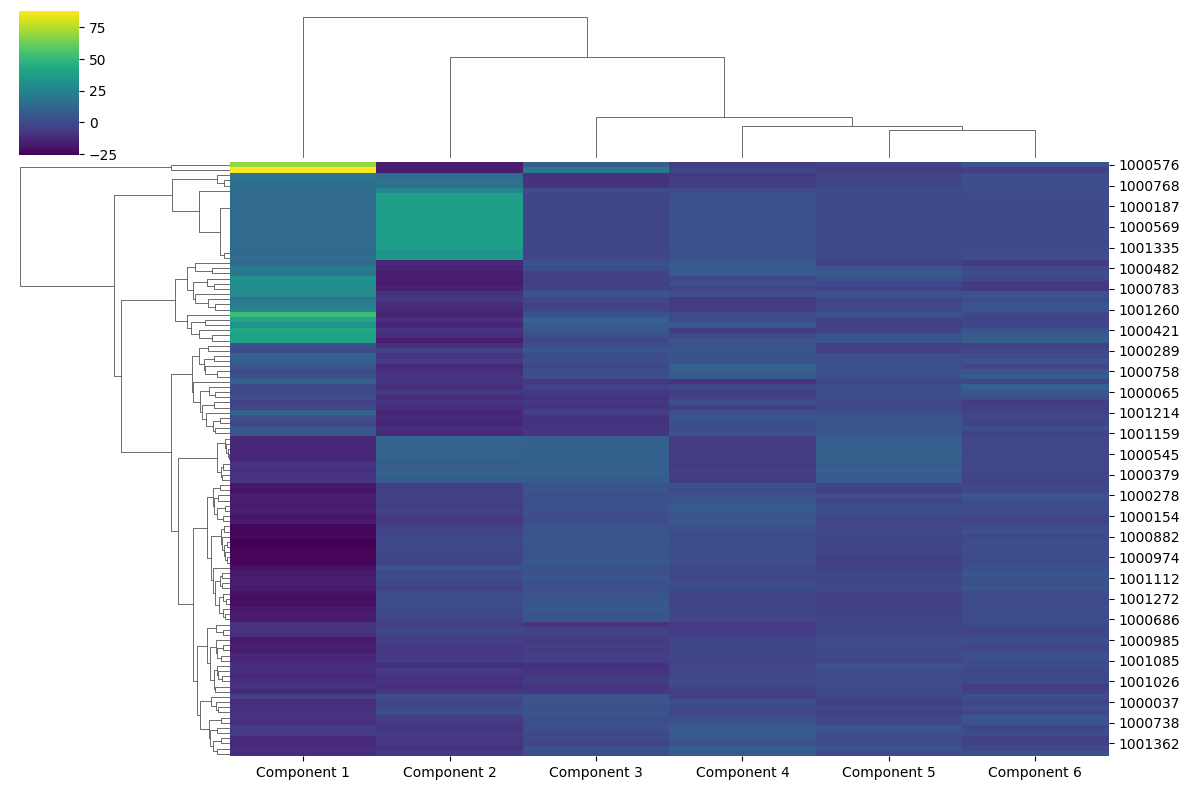

In [43]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load data
dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
filename = os.path.join(dir_path, 'lab_data_exploration.csv')
df = pd.read_csv(filename, sep=',', header=0, index_col=0)

# Extract the feature columns and sample data
feature_names = df.columns
samples = df.values

# Extract patients ids
patient_ids = df.index.values

# Standardize the data before calculating distances
scaler = StandardScaler()
scaled_samples = scaler.fit_transform(samples)

# Calculate pairwise Euclidean distances
similarities = euclidean_distances(scaled_samples)

# Debugging: Output non-finite values in the similarities matrix
nan_count = np.sum(np.isnan(similarities))
inf_count = np.sum(np.isinf(similarities))
print("Number of NaN values:", nan_count)
print("Number of infinite values:", inf_count)

# Replace NaN with infinity
similarities[np.isnan(similarities)] = np.inf

# Multidimensional scaling
seed = np.random.RandomState(seed=3)
mds = PCA(n_components=6, random_state=seed)  # Using 6 components
pos = mds.fit_transform(similarities)

# Create a DataFrame with the MDS positions and patient IDs
mds_df = pd.DataFrame(pos, columns=[f'Component {i+1}' for i in range(6)], index=patient_ids)

# Set up the matplotlib figure, make it big!
plt.figure(figsize=(15, 10))

# Create a cluster map using seaborn
sns.clustermap(mds_df, cmap='viridis', method='average', metric='euclidean', figsize=(12, 8))

plt.show()

Number of NaN values: 0
Number of infinite values: 0


/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=sel

<Figure size 1500x1000 with 0 Axes>

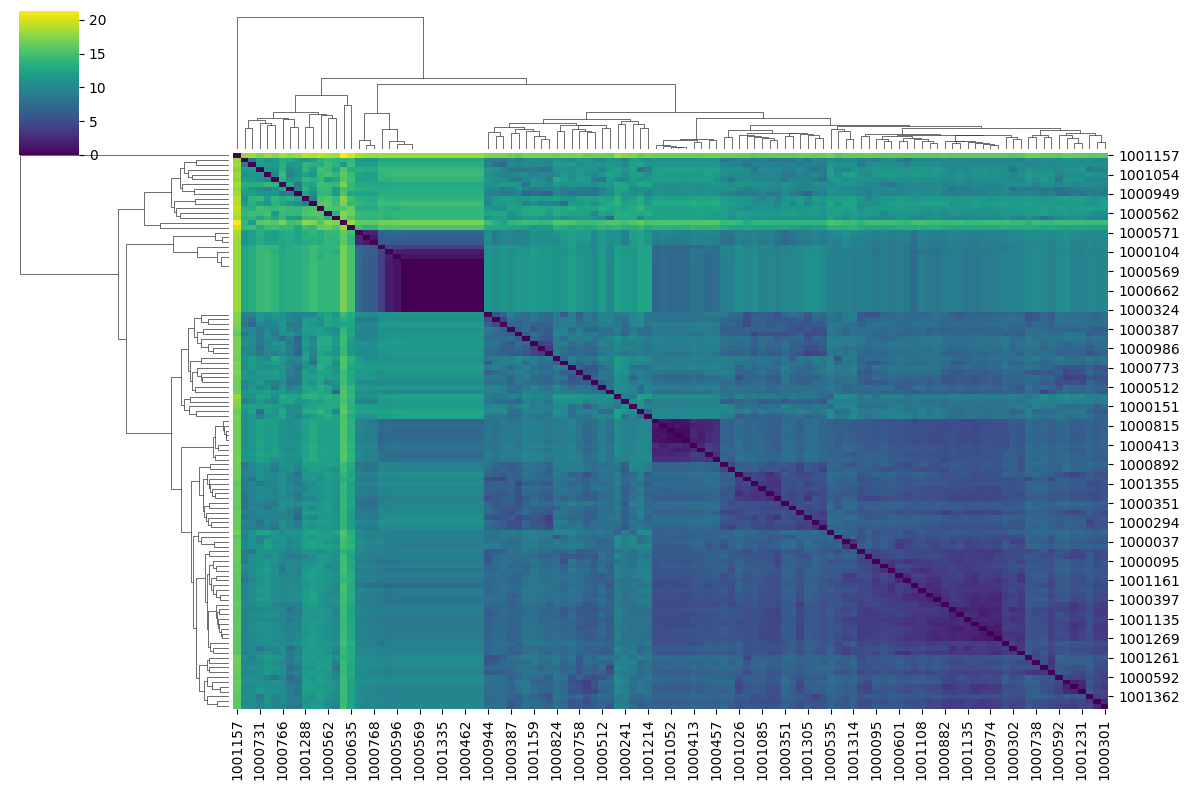

In [44]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import euclidean_distances
from sklearn.preprocessing import StandardScaler

# Load data
dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
filename = os.path.join(dir_path, 'lab_data_exploration.csv')
df = pd.read_csv(filename, sep=',', header=0, index_col=0)

# Extract the feature columns and sample data
feature_names = df.columns
samples = df.values

# Extract patients ids
patient_ids = df.index.values

# Standardize the data before calculating distances
scaler = StandardScaler()
scaled_samples = scaler.fit_transform(samples)

# Calculate pairwise Euclidean distances
similarities = euclidean_distances(scaled_samples)

# Debugging: Output non-finite values in the similarities matrix
nan_count = np.sum(np.isnan(similarities))
inf_count = np.sum(np.isinf(similarities))
print("Number of NaN values:", nan_count)
print("Number of infinite values:", inf_count)

# Replace NaN with infinity
similarities[np.isnan(similarities)] = np.inf

# Create a DataFrame with the similarities and feature names
similarities_df = pd.DataFrame(similarities, columns=patient_ids, index=patient_ids)

# Set up the matplotlib figure, make it big!
plt.figure(figsize=(15, 10))

# Create a cluster map using seaborn
sns.clustermap(similarities_df, cmap='viridis', method='average', metric='euclidean', figsize=(12, 8))

plt.show()